<a href="https://colab.research.google.com/github/toyo97/rgbd-domain-adaptation/blob/master/RGB_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GABRIELE

**Setup**

In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

In [0]:
root="RGB Project"

In [26]:
!unzip -n -q "drive/My Drive/MLDL2020/ROD.zip" -d "RGB Project"
!unzip -n -q "drive/My Drive/MLDL2020/synROD.zip" -d "RGB Project"
!cp "drive/My Drive/RGB Project/ROD/reading.txt" "RGB Project/ROD"
!cp "drive/My Drive/RGB Project/synROD/reading.txt" "RGB Project/synROD"

error:  zipfile read error


In [0]:
from torchvision.datasets import VisionDataset
import glob

from PIL import Image

import os
import os.path
import sys


def create_txt_dataset(root, ROD=True):

  numCat = -1
  if ROD:
    filename = os.path.join(root,"ROD","reading.txt")
    if os.path.isfile(filename):
      raise FileExistsError
    with open(filename, 'w') as outfile:

      RGB_folder = os.path.join(root,"ROD","ROD_rgb")
      depth_folder = os.path.join(root,"ROD","ROD_surfnorm")
      for class_object in sorted(os.listdir(RGB_folder)):
        path = os.path.join(RGB_folder, class_object)
        if os.path.isdir(path):
          numCat+=1
          for subfolder in os.listdir(path):
            subpath = os.path.join(path, subfolder)
            if os.path.isdir(subpath):
              rgb_path = os.path.join(subpath, "*.png")
              root_depth_path = os.path.join(depth_folder, class_object, subfolder)
              for image_rgb in glob.glob(rgb_path):
                image_name = "_".join(image_rgb.split("/")[-1].split("_")[:-1]) + "_depthcrop.png"
                image_depth = os.path.join(root_depth_path, image_name)
                if os.path.isfile(image_depth):
                  outfile.write(image_rgb+","+image_depth+","+str(numCat)+"\n")

  else:
      filename = os.path.join(root,"synROD","reading.txt")
      if os.path.isfile(filename):
        raise FileExistsError
      with open(filename, 'w') as outfile:
        for class_object in sorted(os.listdir(os.path.join(root,"synROD"))):
            path = os.path.join(root,"synROD", class_object)
            if os.path.isdir(path):
              numCat+=1
              rgb_path = os.path.join(path, "rgb", "*.png")
              root_depth_path = os.path.join(path, "depth")
              for image_rgb in glob.glob(rgb_path):
                image_depth = os.path.join(root_depth_path, image_rgb.split("/")[-1])
                if os.path.isfile(image_depth):
                  outfile.write(image_rgb+","+image_depth+","+str(numCat)+"\n")
  outfile.close()

In [28]:
try:
  create_txt_dataset(root,True)
except FileExistsError:
  print("File already created and copied from Drive")
try:
  create_txt_dataset(root,False)
except FileExistsError:
  print("File already created and copied from Drive")

File already created and copied from Drive
File already created and copied from Drive


In [0]:
imgnet_mean, imgnet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

**Define Data Processing**

In [0]:
from torchvision import transforms

train_transform = transforms.Compose([ transforms.Resize((256,256)),
                                      transforms.RandomCrop(224), # random crop for training
                                      transforms.ToTensor(),                                     
                                      transforms.Normalize( mean=imgnet_mean, # ImageNet mean and std
                                                            std=imgnet_std)]
)

val_transform = transforms.Compose([ transforms.Resize((256,256)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize( mean=imgnet_mean,
                                                          std=imgnet_std)]
)

In [0]:
import tqdm
def pil_loader(path):

    with open(path, 'rb') as f:

        img = Image.open(f)
        return img.convert('RGB')


class syn_ROD(VisionDataset):
  
    def __init__(self, root, dataset, RAM, transform=None, target_transform=None):
        super(syn_ROD, self).__init__(root, transform=transform, target_transform=target_transform)

        self.images=[]
        self.categories={}
        self.RAM=RAM
        
        if dataset not in ["ROD", "synROD"]:
          raise ValueError("Dataset not acceptable")

        filename = os.path.join(root,dataset,"reading.txt")

        num_lines = sum(1 for line in open(filename))
        pbar = tqdm.tqdm(total=num_lines,position=0, leave=True)
        for line in open(filename,"r").read().splitlines():
          pbar.update(1)
          field = line.split(",")
          if RAM:
            self.images.append(((pil_loader(field[0]), pil_loader(field[1])), int(field[2])))
          else:
            self.images.append(((field[0],field[1]),int(field[2])))

          

    def __getitem__(self, index):

        images, label = self.images[index] 

        if self.transform is not None:

            if self.RAM:
              image1 = self.transform(images[0])
              image2 = self.transform(images[1])
            else:
              image1 = self.transform(pil_loader(images[0]))
              image2 = self.transform(pil_loader(images[1]))

        return image1,image2, label

    def __len__(self):

        length = len(self.images) 

        return length

In [35]:
source_dataset = syn_ROD(root,"synROD",RAM = False, transform=train_transform)
target_dataset = syn_ROD(root, "ROD", RAM = False, transform=val_transform)

100%|██████████| 41877/41877 [00:00<00:00, 439748.71it/s]


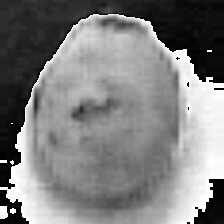

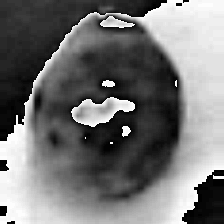

drive/My Drive/RGB Project/ROD/ROD_rgb/apple/apple_1/apple_1_1_146_crop.png
drive/My Drive/RGB Project/ROD/ROD_surfnorm/apple/apple_1/apple_1_1_146_depthcrop.png


In [75]:
foto = 32000
display(transforms.ToPILImage()(target_dataset[foto][0][0]))
display(transforms.ToPILImage()(target_dataset[foto][0][1]))
print(target_dataset.images[4][0][0])
print(target_dataset.images[4][0][1])

#VITTORIO

In [76]:
!find "/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/" -iname *56_crop.png | head -5

/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/apple/apple_1/apple_1_1_156_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/apple/apple_1/apple_1_1_56_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/apple/apple_1/apple_1_2_56_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/apple/apple_1/apple_1_2_156_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/apple/apple_1/apple_1_4_156_crop.png


## Rotation transformation

Source: https://pytorch.org/docs/stable/torchvision/transforms.html

In [0]:
import torch
import torchvision.transforms.functional as TF
from torchvision import transforms
import random
import numpy as np

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        new_tensor = torch.empty(tensor.size())
        for i, t, m, s in zip(range(3), tensor, self.mean, self.std):
            new_tensor[i,:,:] = t.mul(s).add(m)

        return new_tensor

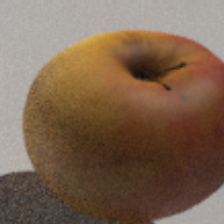

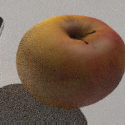

In [97]:
# Usage of UnNormalize
prova=source_dataset.__getitem__(4)[0]
display(transforms.ToPILImage()(UnNormalize(imgnet_mean, imgnet_std)(prova)))
display((pil_loader(source_dataset.images[4][0][0])))

In [0]:
def coupled_rotation(image_tuple): # first img in tuple is RGB

  j = random.randint(0,3)
  k = random.randint(0,3)

  z = (k-j) % 4

  # Note: TF.rotate is counter-clockwise
  rotated_image_tuple = TF.rotate(image_tuple[0], 270*j), TF.rotate(image_tuple[1], 270*k)

  return rotated_image_tuple, z


def transform_batch(rgb_batch, depth_batch):
  """
  params: both rgb_batch and depth_batch are tensors of shape (BATCH_SIZE, 3, 224, 224)
  """

    # F: from normalized tensor, to unnormalized PIL image
  F = transforms.Compose([
                            UnNormalize(imgnet_mean, imgnet_std),
                            transforms.ToPILImage()
  ])
    # G: inverseF
  G = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(imgnet_mean, imgnet_std)
  ])

  # New batches with rotation labels
  new_rgb_batch = torch.empty(rgb_batch.size())
  new_depth_batch = torch.empty(depth_batch.size())
  labels = torch.empty(rgb_batch.size()[0], dtype=torch.int)

  for i in range(rgb_batch.size()[0]):
    # denormalize and back to PIL image
    rotated_images, labels[i] = coupled_rotation((F(rgb_batch[i,:,:,:]), F(depth_batch[i,:,:,:])))
    new_rgb_batch[i,:,:,:], new_depth_batch[i,:,:,:] = G(rotated_images[0]), G(rotated_images[1])

  return new_rgb_batch, new_depth_batch, labels

CHECK NORMALIZE - ROTATION

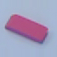

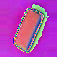

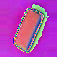

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [165]:
img_path_a = '/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_56_crop.png'
a = Image.open(img_path_a).convert('RGB')
m=transforms.Normalize( mean=imgnet_mean, std=imgnet_std)(transforms.ToTensor()(TF.rotate(a,90)))
n=transforms.ToTensor()(TF.rotate(transforms.ToPILImage()(transforms.Normalize( mean=imgnet_mean, std=imgnet_std)(transforms.ToTensor()(a))),90))
display(a)
display(transforms.ToPILImage()(n))
display(transforms.ToPILImage()(m))
print(torch.eq(n,m))

**TEST**

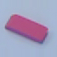

In [166]:
img_path_a = '/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_56_crop.png'
a = Image.open(img_path_a).convert('RGB')

display(a)

In [167]:
img_tensor = train_transform(a)
img_batch = img_tensor.unsqueeze(0)
img_batch.size()

torch.Size([1, 3, 224, 224])

In [0]:
rgb_batch, depth_batch, labels = transform_batch(img_batch, img_batch)

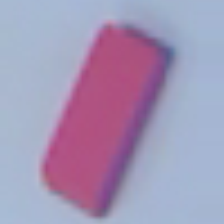

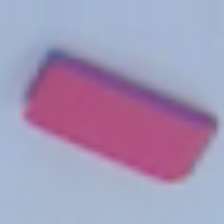

"How many times should the first image be rotated by 90 degrees clockwise to align with the second?"
3 time(s), i.e. relative rotation of 270 degrees


In [196]:
F = transforms.Compose([
                            UnNormalize(imgnet_mean, imgnet_std),
                            transforms.ToPILImage()
  ])

display(F(rgb_batch.squeeze()))
display(F(depth_batch.squeeze()))
z = labels[0]
print('"How many times should the first image be rotated by 90 degrees clockwise to align with the second?"')
print(f'{z} time(s), i.e. relative rotation of {z * 90} degrees')

**Imports**

In [0]:
import torch
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torch.utils.data.dataset import random_split
from torch.backends import cudnn

**Hyperparameters**

In [0]:
DEVICE = 'cuda'      # 'cuda' or 'cpu'

LR = 10e-3
MOMENTUM = 0.9
STEP_SIZE = 10
GAMMA = 0.1
# TODO see if batch size should be different for main and pretext
BATCH_SIZE = 100

LAMBDA = 0.1 # weights contribution of the pretext loss to the total objective

**Prepare DataLoaders**

In [0]:
# Data loaders for synROD - MAIN/PRETEXT task only at training
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# Data loader for ROD train and test - PRETEXT at train, MAIN at test (check validity of drop last when testing)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

**Prepare Network**



In [0]:
net = Net()

**Prepare Training**

In [0]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()
# random crop for training
    def step(self):
        for op in self.optimizers:
            op.step()

In [0]:
# Define loss
# Both main and pretext losses are computed with the cross entropy function
criterion = nn.CrossEntropyLoss()

# Define optimizer
# TODO try with different optimizers for the three components of the network
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
# Define the number of iterations
# Largest dataset rules
NUM_ITER = max(len(source_train_dataset), len(target_train_dataset)) // BATCH_SIZE

In [0]:
# Allow iterating over a dataset more than once
# to deal with different number of samples between datasets
# during training and batch sampling
def loopy(dl):
  while True:
    for x in dl: yield x

**Training**

In [0]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

for epoch in range(2):  # loop over the dataset multiple times

  running_loss_m = 0.0
  running_loss_p = 0.0
  
  source_data_iter = loopy(source_dataloader)
  target_data_iter = loopy(target_dataloader)

  for it in range(NUM_ITER):

    # set to train and zero the parameter gradients
    net.train()
    optimizer.zero_grad()

    # ************************
    # SOURCE MAIN FORWARD PASS
    # ************************
    # unpack in RGB images, depth images and labels
    rimgs, dimgs, labels = next(source_data_iter)

    # Bring data over the device of choice
    rimgs = rimgs.to(DEVICE)
    dimgs = dimgs.to(DEVICE)
    labels = labels.to(DEVICE)

    # forward
    outputs = net(rimgs, dimgs)
    # compute main loss
    loss_m = criterion(outputs, labels)
    loss_m.backward()

    # ***************************
    # SOURCE PRETEXT FORWARD PASS
    # ***************************
    # using same batch as main forward pass
    rimgs, dimgs, labels = transform_batch(rimgs, dimgs)

    rimgs = rimgs.to(DEVICE)
    dimgs = dimgs.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(rimgs, dimgs, LAMBDA)

    loss_sp = criterion(outputs, labels)
    loss_sp.backward()

    # ***************************
    # TARGET PRETEXT FORWARD PASS
    # ***************************

    rimgs, dimgs, _ = next(target_data_iter)
    rimgs, dimgs, labels = transform_batch(rimgs, dimgs)

    rimgs = rimgs.to(DEVICE)
    dimgs = dimgs.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(rimgs, dimgs, 'pretext')

    loss_tp = criterion(outputs, labels))
    loss_tp.backward()

    # update weights
    optimizer.step()

    # print statistics
    running_loss_m += loss_m.item()
    running_loss_p += (loss_sp+loss_tp).item()
    if it % 100 == 99:    # print every 100 mini-batches
      print(f'[{epoch+1}, {it+1}] Lm {running_loss_m/100}, Lp {running_loss_p/100}')
      running_loss_m = 0.
      running_loss_p = 0.

  scheduler.step()

print('Finished Training')

#EMANUELE

In [0]:
from torchvision import models
import torch
import torch.nn as nn
import numpy as np

In [0]:
class LambdaRev(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output, lamda):
        return grad_output.mul(lamda)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.resnet18 = models.resnet18(pretrained=True)
    self.depthFeatureExtractor = nn.Sequential(*(list(self.resnet18.children())[:-2])) # Eliminate last fc and avg pool
    self.rgbFeatureExtractor = nn.Sequential(*(list(self.resnet18.children())[:-2])) # Eliminate last fc and avg pool
    
    self.mainHead = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), # output has shape (batch_size, num_featues, 1, 1)
        nn.Linear(512 , 1000),        # wants first dimension = batch_size
                                      # In resnet18 it is 512 * block.expansion -> ???
        nn.BatchNorm1d(num_features=1000),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(1000, NUM_CLASSES),
        nn.Softmax()
    )

    nn.init.xavier_normal_(self.mainHead[1].weight, gain=1.0)
    nn.init.xavier_normal_(self.mainHead[5].weight, gain=1.0)

    self.pretextHead = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=100, kernel_size=(1,1), bias=True, stride=1, padding=0), # output img = 100 channels of 7x7
        nn.BatchNorm2d(num_features=100),
        nn.ReLU(),
        nn.Conv2d(in_channels=100, out_channels=100, kernel_size=(3,3), bias=True, stride=2, padding=0), # output img = 100 channels of 98x98
        nn.BatchNorm2d(num_features=100),
        nn.ReLU(),
        nn.Linear(100*98*98, 100),
        nn.BatchNorm1d(num_features=100),
        nn.ReLU(),
        nn.Linear(100, 4),
        nn.Softmax()
    )
    
    nn.init.xavier_normal_(self.pretextHead[0].weight, gain=1.0)
    nn.init.xavier_normal_(self.pretextHead[3].weight, gain=1.0)
    nn.init.xavier_normal_(self.pretextHead[6].weight, gain=1.0)
    nn.init.xavier_normal_(self.pretextHead[9].weight, gain=1.0)
    

  def forward(self, x, y, lamda=None): # x is the rgb batch, y the depth batch
    rgbFeatures = self.rgbFeatureExtractor(x) # list of rgb filters of the batch (list_size = batch_size)
    depthFeatures = self.depthFeatureExtractor(y) 
    totFeatures = torch.cat((depthFeatures, rgbFeatures), 1) # To check: concatenate along right direction? 
                                                          # size_allFeatures = (batch_size, number_filters, height, width)
                                                          # number_filters = 512
                                                          # height = width = 7 if input of network is 224x224
    if lamda is None: # S in the paper
      out1 = self.mainHead[0](totFeatures)
      out1 = torch.flatten(out1, 1)  # size = batch_size, num_features*h*w 
      out1 = self.mainHead[1](out1)
      out1 = self.mainHead[2](out1)
      out1 = self.mainHead[3](out1)
      out1 = self.mainHead[4](out1)
      class_scores = self.mainHead[5](out1) # class scores of the batch
      return class_scores

    else: # Stilda, Tdilda, T in the paper
      out2 = LambdaRev.apply(allFeatures, lamda) # lambda mul in backward pass

      out2 = self.pretextHead[0](totFeatures)
      out2 = self.pretextHead[1](out2)
      out2 = self.pretextHead[2](out2)
      out2 = self.pretextHead[3](out2)
      out2 = self.pretextHead[4](out2)
      out2 = self.pretextHead[5](out2)

      out2 = torch.flatten(out2, 1)

      out2 = self.pretextHead[6](out2)
      out2 = self.pretextHead[7](out2)
      out2 = self.pretextHead[8](out2)
      out2 = self.pretextHead[9](out2)
      rotation_scores = self.pretextHead[10](out2)
      return rotation_scores